In [40]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("properties_2017.csv")
    dataO = pd.read_csv("properties_2016.csv")
    #data = pd.read_csv("train_2017.csv")
    print "dataset has {} samples with {} features each.".format(*data.shape)
    print "Older dataset has {} samples with {} features each.".format(*dataO.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

dataset has 2985217 samples with 58 features each.
Older dataset has 2985217 samples with 58 features each.


In [41]:
#(data.ix[:,49]).isnull().values.all() # if all values of column 49 are null 
#(data.ix[:,49]).isnull().sum() #column 49 s count of null values
#data.ix[:,49].loc[~(data.ix[:,49]).isnull()] #not null values of column 49
dataO.loc[dataO['parcelid']==10711910]
data.loc[dataO['heatingorsystemtypeid']==9].head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock


In [42]:
#Remove columns with too many nulls
#for i in data.columns[:]:
    #if((data[i]).isnull().sum() > 1000000): #returns true if count of nulls in a column exceeds 1000000
#    print (data[i]).isnull().sum()
try:
    trans = pd.read_csv("train_2017.csv")
    transO = pd.read_csv("train_2016.csv")
    #sample = pd.read_csv("sample_submission.csv")
    print "transaction dataset has {} samples with {} features each.".format(*trans.shape)
    print "Older transaction dataset has {} samples with {} features each.".format(*transO.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

transaction dataset has 77613 samples with 3 features each.
Older transaction dataset has 90275 samples with 3 features each.


In [43]:
#data_reduced[~data_reduced['parcelid'].isin(trans['parcelid'])].index
transO.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [44]:
trans = pd.concat([trans.drop('transactiondate', axis = 1), 
          (trans.transactiondate.str.split("-|T").str[:3].apply(pd.Series)
          .rename(columns={0:'Tyear', 1:'Tmonth', 2:'Tday'}))], axis = 1)

In [45]:
transO = pd.concat([transO.drop('transactiondate', axis = 1), 
          (transO.transactiondate.str.split("-|T").str[:3].apply(pd.Series)
          .rename(columns={0:'Tyear', 1:'Tmonth', 2:'Tday'}))], axis = 1)

In [46]:
merged = [trans,transO]
result = pd.concat(merged)

In [47]:
#sorted(result['Tyear'].unique())
#result.shape
#result.duplicated('parcelid') 
#len(result['parcelid'].unique())
#len(result['parcelid'])

In [48]:
#all those rows in data_reduced whose parcelid dont match with those in trans
data_reduced = data.drop(data[~data['parcelid'].isin(trans['parcelid'])].index)
#trans[trans['parcelid'] == 17054981]

In [49]:
dataO_reduced = dataO.drop(dataO[~dataO['parcelid'].isin(transO['parcelid'])].index)
#transO[transO['parcelid'] == 17100444]

In [50]:
dataO_reduced.shape

(90150, 58)

In [51]:
merged = [data_reduced, dataO_reduced]
data_reduced_comb = pd.concat(merged)

In [52]:
#data_trans_reduced_comb.loc[data_trans_reduced_comb['parcelid'] == 10711923]

In [53]:
#test = pd.merge(data_reduced_comb,result,on='parcelid',how='left') #preliminary

In [54]:
#result[~result['parcelid'].isin(data_trans_reduced_comb_f['parcelid'])]
#data_reduced_comb[~(data_reduced_comb['assessmentyear'].isnull()) & data_reduced_comb['assessmentyear'] != data_reduced_comb['']]
#data_reduced_comb_trans[data_reduced_comb_trans['assessmentyear'].isnull()].groupby('parcelid').size()

data_trans_reduced_comb_p = pd.merge(data_reduced_comb,result,on='parcelid') #preliminary

#remove the whole null row
data_trans_reduced_comb_p = data_trans_reduced_comb_p.drop(data_trans_reduced_comb_p[data_trans_reduced_comb_p['parcelid'] == 11491470].index)
data_trans_reduced_comb_p.shape

(172599, 62)

In [55]:
data_trans_reduced_comb_f = data_trans_reduced_comb_p[data_trans_reduced_comb_p['assessmentyear'] == (data_trans_reduced_comb_p['Tyear']).astype(int) - 1] #final
data_trans_reduced_comb_f.shape

#print data_trans_reduced_comb_p[data_trans_reduced_comb_p['assessmentyear'] == (data_trans_reduced_comb_p['Tyear']).astype(int) - 1] #final
#sorted(data_reduced_comb_trans['parcelid'])
#np.where(data_reduced_comb_trans.groupby('parcelid').size() == 2)

(167854, 62)

In [56]:
pd.set_option('display.max_columns', None)

In [57]:
pd.options.display.max_rows = 4000

In [58]:
data_trans_reduced_comb_f.head()
data_trans_reduced_comb_f.shape

(167854, 62)

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
data_trans_reduced_comb_f.loc[:,'abslogerror'] = data_trans_reduced_comb_f['logerror'].abs() #add new column
data_trans_reduced_comb_f.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,Tyear,Tmonth,Tday,abslogerror
0,17054981,NaN,NaN,NaN,5.0,4.0,NaN,NaN,5.0,NaN,1968.0,3760.0,3760.0,NaN,NaN,1968.0,NaN,6111.0,4.0,5.0,3.0,784.0,NaN,NaN,34449407.0,-119254052.0,42688.0,1.0,735.0,NaN,NaN,1.0,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,1982.0,2.0,NaN,501928.0,872850.0,2016.0,370922.0,9673.46,NaN,NaN,6.111001e+13,-0.013099,2017,06,15,0.013099
1,17055743,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,66.0,1444.0,1444.0,1444.0,NaN,NaN,1444.0,NaN,6111.0,NaN,2.0,1.0,0.0,NaN,NaN,34454169.0,-119237898.0,7108.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1951.0,1.0,NaN,130845.0,436157.0,2016.0,305312.0,5538.80,NaN,NaN,6.111001e+13,0.073985,2017,07,26,0.073985
2,17068109,NaN,NaN,NaN,1.5,3.0,NaN,NaN,1.5,66.0,1698.0,1698.0,1698.0,NaN,NaN,1698.0,NaN,6111.0,1.0,1.0,0.0,0.0,NaN,NaN,34365693.0,-119448392.0,2588.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,34543.0,2061.0,NaN,97081.0,6.0,NaN,1.0,NaN,NaN,NaN,NaN,1979.0,1.0,NaN,193413.0,286606.0,2016.0,93193.0,2987.36,NaN,NaN,6.111001e+13,0.071886,2017,07,28,0.071886
3,17073952,NaN,NaN,NaN,2.0,2.0,NaN,NaN,2.0,NaN,986.0,986.0,986.0,NaN,NaN,986.0,NaN,6111.0,1.0,2.0,1.0,0.0,NaN,NaN,34305600.0,-119284000.0,NaN,NaN,NaN,NaN,NaN,NaN,1129,266.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97081.0,4.0,NaN,NaN,NaN,NaN,55.0,NaN,1989.0,1.0,NaN,90357.0,258888.0,2016.0,168531.0,2706.24,NaN,NaN,6.111002e+13,0.305680,2017,06,02,0.305680
4,17078502,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1170.0,1170.0,1170.0,NaN,NaN,1170.0,NaN,6111.0,1.0,1.0,2.0,621.0,NaN,NaN,34278012.0,-119257047.0,5643.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97083.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,1.0,NaN,148752.0,592930.0,2016.0,444178.0,6220.70,NaN,NaN,6.111002e+13,-0.073787,2017,07,07,0.073787


In [61]:
import matplotlib as mlp
import matplotlib.pyplot as plt
from matplotlib.pyplot import colorbar
from matplotlib.text import Text

In [62]:
'''
fig, ax = plt.subplots(figsize=(size, size))
t = Text(verticalalignment='top')
plt.xticks(range(len(corr.columns)), corr.columns, verticalalignment='top', rotation = 90, size=40)
plt.yticks(range(len(corr.columns)), corr.columns, size=40)
plt.imshow(corr, cmap='hot')
#aspect='auto',shape=(corr.iterrows,corr.columns, interpolation='nearest') 
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=50)
#plt.show()
#ax.matshow(corr)  
'''


"\nfig, ax = plt.subplots(figsize=(size, size))\nt = Text(verticalalignment='top')\nplt.xticks(range(len(corr.columns)), corr.columns, verticalalignment='top', rotation = 90, size=40)\nplt.yticks(range(len(corr.columns)), corr.columns, size=40)\nplt.imshow(corr, cmap='hot')\n#aspect='auto',shape=(corr.iterrows,corr.columns, interpolation='nearest') \ncbar = plt.colorbar()\ncbar.ax.tick_params(labelsize=50)\n#plt.show()\n#ax.matshow(corr)  \n"

In [63]:
def plot_corr(df,size=8):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    plt.figure(figsize = (12,12))
    sns.heatmap(corr)
    plt.title("Important variables correlation map", fontsize=15)
    plt.show()    

In [64]:
data_trans_reduced_comb_f.isnull().sum()

parcelid                             0
airconditioningtypeid           114066
architecturalstyletypeid        167386
basementsqft                    167761
bathroomcnt                          0
bedroomcnt                           0
buildingclasstypeid             167823
buildingqualitytypeid            60681
calculatedbathnbr                 1798
decktypeid                      166582
finishedfloor1squarefeet        154961
calculatedfinishedsquarefeet       862
finishedsquarefeet12              8335
finishedsquarefeet13            167779
finishedsquarefeet15            161263
finishedsquarefeet50            154961
finishedsquarefeet6             167047
fips                                 0
fireplacecnt                    149958
fullbathcnt                       1798
garagecarcnt                    112397
garagetotalsqft                 112397
hashottuborspa                  163950
heatingorsystemtypeid            62203
latitude                             0
longitude                

In [65]:
data_trans_reduced_comb_f.dtypes

parcelid                          int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottuborspa                   object
heatingorsystemtypeid           float64
latitude                        float64


In [66]:
from sklearn import preprocessing
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.grid_search import GridSearchCV

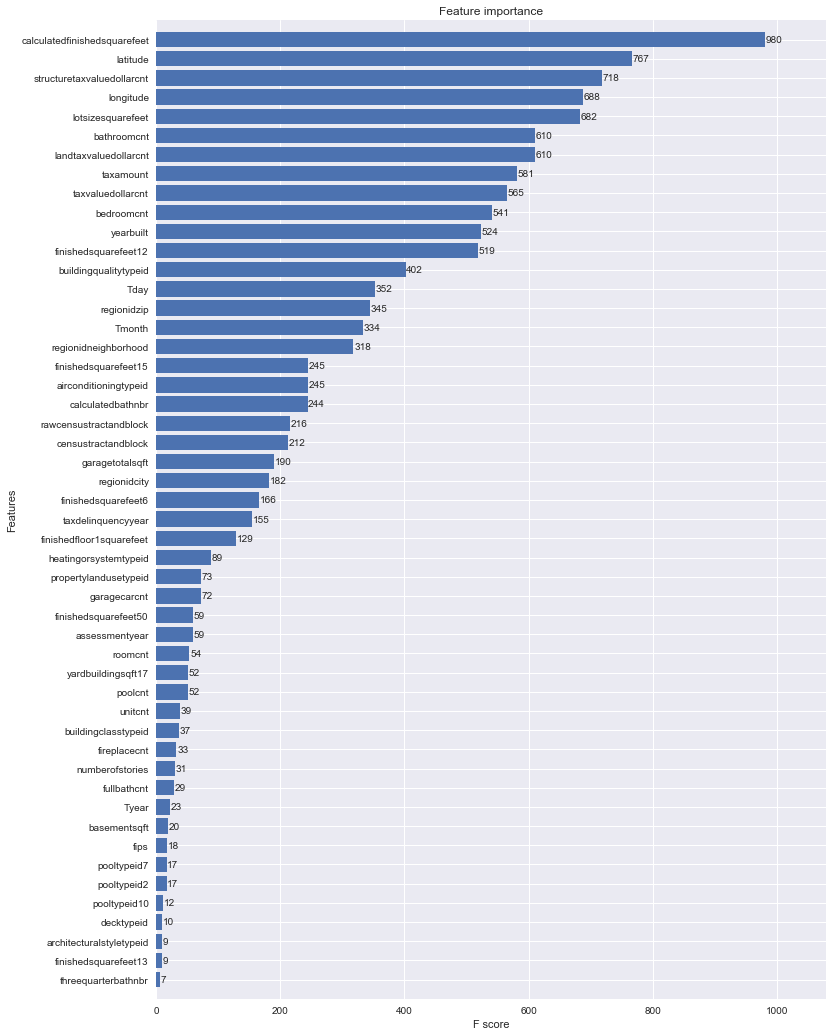

In [67]:
#*** Feature importance evaluation ***#

train_y = data_trans_reduced_comb_f['logerror'].values
df_train = data_trans_reduced_comb_f.drop(['parcelid', 'logerror','abslogerror','taxdelinquencyflag','fireplaceflag','propertyzoningdesc','propertycountylandusecode','hashottuborspa'], axis=1)
feat_names = df_train.columns.values

for c in df_train.columns:
    if df_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[c].values))
        df_train[c] = lbl.transform(list(df_train[c].values))

#import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(df_train, train_y, feature_names=df_train.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=150)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

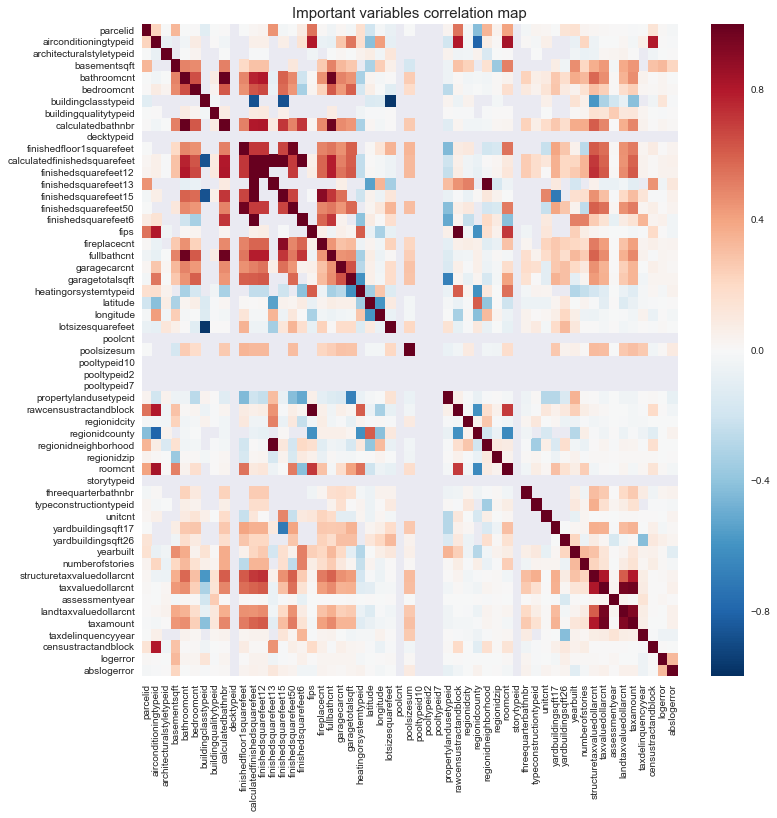

In [68]:
plot_corr(data_trans_reduced_comb_f)

In [248]:
dropcols = ['finishedsquarefeet12','finishedsquarefeet13', 'finishedsquarefeet15','finishedsquarefeet6']

#finishedsquarefeet50 and finishedfloor1squarefeet are the exactly the same information according to the dictionary descriptions, lets remove finishedsquarefeet50 as it has more missing values
dropcols.append('finishedsquarefeet50')

#'bathroomcnt' and 'calculatedbathnbr' and 'fullbathcnt' seem to be the same information aswell according to the dictionary descriptions. Choose 'bathroomcnt' as has no missing values, so remove the other two
dropcols.append('calculatedbathnbr')
dropcols.append('fullbathcnt')
dropcols.append('taxvaluedollarcnt')
dropcols.append('finishedfloor1squarefeet')
dropcols.append('calculatedbathnbr')
dropcols.append('fireplaceflag')
dropcols.append('garagecarcnt')
dropcols.append('pooltypeid7')
dropcols.append('regionidcounty')
dropcols.append('regionidcity')
dropcols.append('regionidzip')
dropcols.append('regionidneighborhood')
dropcols.append('taxdelinquencyflag')
dropcols.append('storytypeid')
dropcols.append('censustractandblock')
dropcols.append('threequarterbathnbr')

In [249]:
after_remov_similar_col_df = data_trans_reduced_comb_f.copy()

In [250]:
missingvalues_prop = (after_remov_similar_col_df.isnull().sum()/len(after_remov_similar_col_df)).reset_index()
missingvalues_prop.columns = ['fields','proportion']
missingvalues_prop = missingvalues_prop.sort_values(by = 'proportion', ascending = False)
print(missingvalues_prop)

                          fields  proportion
6            buildingclasstypeid    0.999815
13          finishedsquarefeet13    0.999553
41                   storytypeid    0.999446
3                   basementsqft    0.999446
46            yardbuildingsqft26    0.999017
49                 fireplaceflag    0.997653
2       architecturalstyletypeid    0.997212
43        typeconstructiontypeid    0.996890
16           finishedsquarefeet6    0.995192
9                     decktypeid    0.992422
29                  pooltypeid10    0.990313
28                   poolsizesum    0.989050
30                   pooltypeid2    0.986429
22                hashottuborspa    0.976742
56            taxdelinquencyyear    0.972101
55            taxdelinquencyflag    0.972101
45            yardbuildingsqft17    0.969980
14          finishedsquarefeet15    0.960734
10      finishedfloor1squarefeet    0.923189
15          finishedsquarefeet50    0.923189
18                  fireplacecnt    0.893384
42        

In [251]:
after_remov_similar_col_df = after_remov_similar_col_df.drop(dropcols, axis=1)

In [253]:
dropcols = missingvalues_prop.loc[(missingvalues_prop['proportion']>0.97),'fields']
dropcols = dropcols[(dropcols !='poolsizesum') & (dropcols !='buildingclasstypeid') & 
                    (dropcols !='typeconstructiontypeid') & (dropcols !='storytypeid') &
                    (dropcols !='architecturalstyletypeid') & (dropcols !='finishedsquarefeet13')
                    & (dropcols !='fireplaceflag') & (dropcols !='finishedsquarefeet6') &
                    (dropcols !='taxdelinquencyflag')
                   ]
after_remov_similar_col_df = after_remov_similar_col_df.drop(dropcols, axis=1)

In [73]:
#after_remov_similar_col_df.loc[after_remov_similar_col_df['structuretaxvaluedollarcnt'].notnull() & after_remov_similar_col_df['landtaxvaluedollarcnt'].notnull() & after_remov_similar_col_df['taxvaluedollarcnt'].notnull(),:].head()

In [254]:
def box_plot(df,label):
    x = df[label]
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True ,
                                        gridspec_kw={"height_ratios": (.15, .85)})
    me = np.mean(x)
    st = x.std(); 
    sns.boxplot(x, ax=ax_box)
    sns.distplot(x, ax=ax_hist, kde=False)
    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.xlim([me-2*st, me+2*st])
    plt.show()

/Users/TheResearcher/Desktop/anaconda/lib/python2.7/site-packages/numpy/linalg/linalg.py:1591: RuntimeWarning: invalid value encountered in greater
  return sum(S > tol)
/Users/TheResearcher/Desktop/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/TheResearcher/Desktop/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/TheResearcher/Desktop/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/TheResearcher/Desktop/anaconda/lib/python2.7/site-packages/ggplot/stats/stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


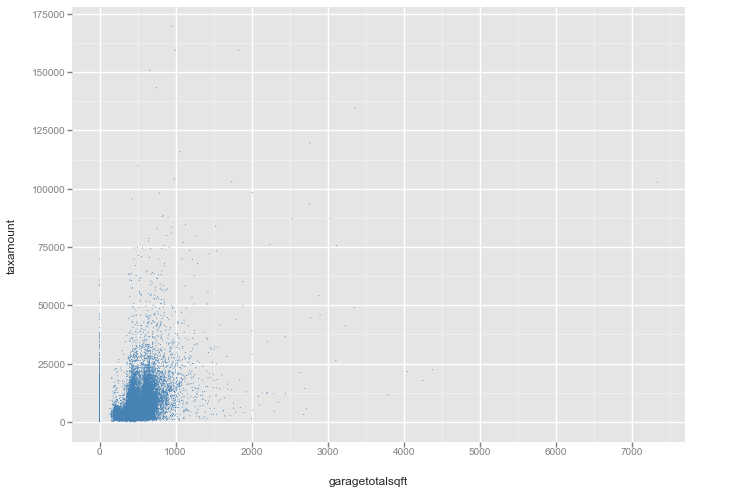

<ggplot: (296255705)>

In [75]:
from ggplot import *
#def plot_ggplot(df,xlabel,ylabel):
ggplot(aes(x='garagetotalsqft', y='taxamount'), data=after_remov_similar_col_df) + \
    geom_point(color='steelblue', size=1) + \
    stat_smooth()    

In [76]:
#data_trans_reduced_comb_f['airconditioningtypeid'].value_counts()

In [256]:
#used after_remov_similar_col_df['unitcnt'].value_counts() to find most frequent value

index = after_remov_similar_col_df.poolcnt.isnull()
after_remov_similar_col_df.loc[index,'poolcnt'] = 0

poolsizesum_median = after_remov_similar_col_df.loc[after_remov_similar_col_df['poolcnt'] > 0, 'poolsizesum'].median()
after_remov_similar_col_df.loc[(after_remov_similar_col_df['poolcnt'] > 0) & (after_remov_similar_col_df['poolsizesum'].isnull()), 'poolsizesum'] = poolsizesum_median

#If it doesn't have a pool then poolsizesum is 0 by default
after_remov_similar_col_df.loc[(after_remov_similar_col_df['poolcnt'] == 0), 'poolsizesum'] = 0

index = after_remov_similar_col_df.fireplacecnt.isnull()
after_remov_similar_col_df.loc[index,'fireplacecnt'] = 0

index = after_remov_similar_col_df.garagetotalsqft.isnull()
after_remov_similar_col_df.loc[index,'garagetotalsqft'] = 0

index = after_remov_similar_col_df.airconditioningtypeid.isnull()
after_remov_similar_col_df.loc[index,'airconditioningtypeid'] = 1

index = after_remov_similar_col_df.heatingorsystemtypeid.isnull()
after_remov_similar_col_df.loc[index,'heatingorsystemtypeid'] = 2

index = after_remov_similar_col_df.numberofstories.isnull()
after_remov_similar_col_df.loc[index,'numberofstories'] = 2

index = after_remov_similar_col_df.yardbuildingsqft17.isnull()
after_remov_similar_col_df.loc[index,'yardbuildingsqft17'] = 200

index = after_remov_similar_col_df.buildingclasstypeid.isnull()
after_remov_similar_col_df.loc[index,'buildingclasstypeid'] = 4

index = after_remov_similar_col_df.typeconstructiontypeid.isnull()
after_remov_similar_col_df.loc[index,'typeconstructiontypeid'] = 6

#index = after_remov_similar_col_df.storytypeid.isnull()
#after_remov_similar_col_df.loc[index,'storytypeid'] = 7

index = after_remov_similar_col_df.architecturalstyletypeid.isnull()
after_remov_similar_col_df.loc[index,'architecturalstyletypeid'] = 7

index = after_remov_similar_col_df.unitcnt.isnull()
after_remov_similar_col_df.loc[index,'unitcnt'] = 1

index = after_remov_similar_col_df.propertyzoningdesc.isnull()
after_remov_similar_col_df.loc[index,'propertyzoningdesc'] = 'LAR1'

In [257]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler

In [258]:
def fillna_knn( df, base, target, fraction = 1, n_neighbors = 1 ):

    #test = data_trans_reduced_comb_f.copy()
    #base = [ 'latitude', 'longitude' ]
    #target = 'buildingqualitytypeid'
    #fraction = 1

    #assert isinstance( base , list ) or isinstance( base , np.ndarray ) and isinstance( target, str ) 
    whole = [ target ] + base

    miss = df[target].isnull()
    notmiss = ~miss 
    nummiss = miss.sum()

    #enc = OneHotEncoder()
    X_target = df.loc[ notmiss, whole ].sample( frac = fraction )

    #enc.fit( X_target[ target ].unique().reshape( (-1,1) ) )
    #Y = enc.transform( X_target[ target ].values.reshape((-1,1)) ).toarray()
    Y = X_target[ target ].values.reshape((-1,1))
    X = X_target[base]

    n_neighbors = n_neighbors
    clf = neighbors.KNeighborsClassifier( n_neighbors, weights = 'uniform' )
    #print(clf)
    clf.fit( X, Y )
    #print( 'the shape of active features: ' ,enc.active_features_.shape )
    Z = clf.predict(df.loc[miss, base])
    #test.loc[ miss, target ]  = np.dot( Z , enc.active_features_ )
    df.loc[ miss, target ]  = Z
    df.loc[miss,:].head()

In [225]:
def fillna_knn_reg( df, base, target, n_neighbors = 5 ):
    cols = base + [target]
    X_train = df[cols]
    scaler = StandardScaler(with_mean=True, with_std=True).fit(X_train[base].values.reshape(-1, 1))
    rescaledX = scaler.transform(X_train[base].values.reshape(-1, 1))

    X_train = rescaledX[df[target].notnull()]
    Y_train = df.loc[df[target].notnull(),target].values.reshape(-1, 1)

    knn = KNeighborsRegressor(n_neighbors, n_jobs = -1)    
    # fitting the model
    knn.fit(X_train, Y_train)
    # predict the response
    X_test = rescaledX[df[target].isnull()]
    pred = knn.predict(X_test)
    df.loc[df_train[target].isnull(),target] = pred
    return


In [259]:
after_enc_by_pop_df = after_remov_similar_col_df.copy()

In [260]:
#after_enc_by_pop_df.buildingqualitytypeid.value_counts().loc[4]
after_enc_by_pop_df.loc[after_enc_by_pop_df['airconditioningtypeid'] == 1,'airconditioningtypeid'] = 3
after_enc_by_pop_df.loc[after_enc_by_pop_df['airconditioningtypeid'] == 13,'airconditioningtypeid'] = 2
after_enc_by_pop_df.loc[after_enc_by_pop_df['airconditioningtypeid'] == 5,'airconditioningtypeid'] = 1
after_enc_by_pop_df.loc[after_enc_by_pop_df['heatingorsystemtypeid'] == 2,'heatingorsystemtypeid'] = 41
after_enc_by_pop_df.loc[after_enc_by_pop_df['heatingorsystemtypeid'] == 7,'heatingorsystemtypeid'] = 40
after_enc_by_pop_df.loc[after_enc_by_pop_df['heatingorsystemtypeid'] == 24,'heatingorsystemtypeid'] = 39
after_enc_by_pop_df.loc[after_enc_by_pop_df['heatingorsystemtypeid'] == 6,'heatingorsystemtypeid'] = 38
after_enc_by_pop_df.loc[after_enc_by_pop_df['heatingorsystemtypeid'] == 20,'heatingorsystemtypeid'] = 37
after_enc_by_pop_df.loc[after_enc_by_pop_df['heatingorsystemtypeid'] == 13,'heatingorsystemtypeid'] = 36
after_enc_by_pop_df.loc[after_enc_by_pop_df['heatingorsystemtypeid'] == 18,'heatingorsystemtypeid'] = 35
after_enc_by_pop_df.loc[after_enc_by_pop_df['heatingorsystemtypeid'] == 1,'heatingorsystemtypeid'] = 34
after_enc_by_pop_df.loc[after_enc_by_pop_df['heatingorsystemtypeid'] == 10,'heatingorsystemtypeid'] = 33
after_enc_by_pop_df.loc[after_enc_by_pop_df['heatingorsystemtypeid'] == 11,'heatingorsystemtypeid'] = 32
after_enc_by_pop_df.loc[after_enc_by_pop_df['heatingorsystemtypeid'] == 14,'heatingorsystemtypeid'] = 31
after_enc_by_pop_df.loc[after_enc_by_pop_df['heatingorsystemtypeid'] == 12,'heatingorsystemtypeid'] = 30
after_enc_by_pop_df.loc[after_enc_by_pop_df['fips'] == 6037,'fips'] = 3
after_enc_by_pop_df.loc[after_enc_by_pop_df['fips'] == 6059,'fips'] = 2
after_enc_by_pop_df.loc[after_enc_by_pop_df['fips'] == 6111,'fips'] = 1

In [261]:
#lbl = preprocessing.LabelEncoder()
#lbl.fit(list(after_enc_by_pop_df['hashottuborspa'].values))
#after_enc_by_pop_df['hashottuborspa'] = lbl.transform(list(after_enc_by_pop_df['hashottuborspa'].values))

lbl = preprocessing.LabelEncoder()
lbl.fit(list(after_enc_by_pop_df['propertyzoningdesc'].values)) 
after_enc_by_pop_df['propertyzoningdesc'] = lbl.transform(list(after_enc_by_pop_df['propertyzoningdesc'].values))

In [262]:
after_scaling_df = after_enc_by_pop_df.copy()

In [263]:
after_scaling_df = after_scaling_df.drop(['parcelid','abslogerror'],axis=1)

In [264]:
fillna_knn_reg(after_scaling_df,['latitude','longitude'],'lotsizesquarefeet')

/Users/TheResearcher/Desktop/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 335708 but corresponding boolean dimension is 167854
/Users/TheResearcher/Desktop/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 335708 but corresponding boolean dimension is 167854


In [265]:
scaling_finished_df = after_scaling_df.copy()

In [233]:
from sklearn.preprocessing import RobustScaler

In [266]:
cols_to_be_knn = ['yearbuilt','structuretaxvaluedollarcnt','landtaxvaluedollarcnt','taxamount','calculatedfinishedsquarefeet'
                 ,'buildingqualitytypeid']

In [267]:
for col in cols_to_be_knn:
    fillna_knn_reg(scaling_finished_df,['latitude','longitude'],col)

/Users/TheResearcher/Desktop/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 335708 but corresponding boolean dimension is 167854
/Users/TheResearcher/Desktop/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 335708 but corresponding boolean dimension is 167854


In [268]:
scaling_finished_df['Tyear'] = (scaling_finished_df['Tyear'].map(str) + scaling_finished_df['Tmonth'] + scaling_finished_df['Tday']).astype(int)

In [269]:
scaling_finished_df.rename(columns = {'Tyear':'TransactionDate'}, inplace = True)

In [270]:
cols_to_be_scaled = ['garagetotalsqft','lotsizesquarefeet','poolsizesum','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','yardbuildingsqft17','yearbuilt','structuretaxvaluedollarcnt','assessmentyear','landtaxvaluedollarcnt','taxamount','TransactionDate']

In [271]:
#scaling_finished_df['propertycountylandusecode'].value_counts()

lbl = preprocessing.LabelEncoder()
lbl.fit(list(scaling_finished_df['propertycountylandusecode'].values)) 
scaling_finished_df['propertycountylandusecode'] = lbl.transform(list(scaling_finished_df['propertycountylandusecode'].values))

In [272]:
for col in cols_to_be_scaled:
    scaler = RobustScaler().fit(scaling_finished_df[col].values.reshape(-1, 1))
    scaling_finished_df[col] = scaler.transform(scaling_finished_df[col].values.reshape(-1, 1))

In [273]:
scaler = RobustScaler().fit(scaling_finished_df['calculatedfinishedsquarefeet'].values.reshape(-1, 1))
scaling_finished_df['calculatedfinishedsquarefeet'] = scaler.transform(scaling_finished_df['calculatedfinishedsquarefeet'].values.reshape(-1, 1))

In [274]:
#scaler = StandardScaler(with_mean=True, with_std=True).fit(after_enc_by_pop_df['longitude'].values.reshape(-1, 1))
#after_enc_by_pop_df['longitude'] = scaler.transform(after_enc_by_pop_df['longitude'].values.reshape(-1, 1))

scaler = RobustScaler().fit(scaling_finished_df['longitude'].values.reshape(-1, 1))
scaling_finished_df['longitude'] = scaler.transform(scaling_finished_df['longitude'].values.reshape(-1, 1))

scaler = RobustScaler().fit(scaling_finished_df['latitude'].values.reshape(-1, 1))
scaling_finished_df['latitude'] = scaler.transform(scaling_finished_df['latitude'].values.reshape(-1, 1))

In [243]:
from sklearn.preprocessing import StandardScaler

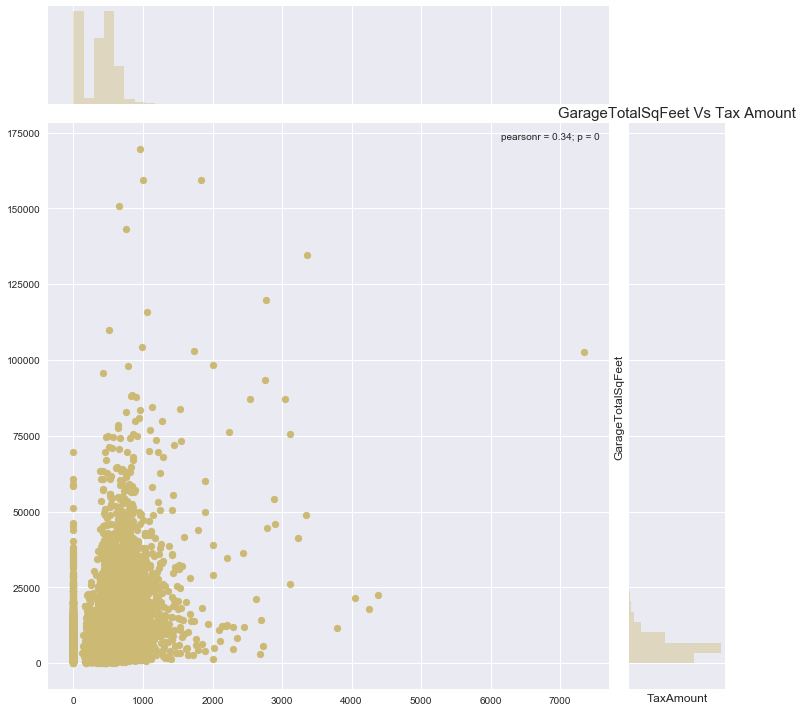

In [244]:
color = sns.color_palette()
plt.figure(figsize=(12,12))
sns.jointplot(x=data_trans_reduced_comb_f.garagetotalsqft.values, y=data_trans_reduced_comb_f.taxamount.values, size=10, color=color[4])
plt.ylabel('GarageTotalSqFeet', fontsize=12)
plt.xlabel('TaxAmount', fontsize=12)
plt.title("GarageTotalSqFeet Vs Tax Amount", fontsize=15)
plt.show()

In [ ]:
#df = data_trans_reduced_comb_f.melt('parcelid',var_name='Columns',  value_name='Values')
#g = sns.factorplot(x="parcelid", y="Values", hue='Columns', data=df)
#data_trans_reduced_comb_f.shape

In [ ]:
#filter rows based on conditional check on column
#data_trans_reduced_comb_f_nn.loc[:,data_trans_reduced_comb_f_nn.isnull().sum() > 1].head()

In [245]:
def plot_countPlot(df,label):
    plt.figure(figsize=(12,8))
    sns.countplot(x=label, data=df)
    plt.ylabel('Count', fontsize=12)
    plt.xlabel(label, fontsize=12)
    plt.xticks(rotation='vertical')
    plt.title("Frequency of "+ label +" count", fontsize=15)
    plt.show()

In [ ]:
#plot_countPlot(after_imputing_df,'propertylandusetypeid')

In [201]:
from ggplot import ggplot, geom_line, aes

In [202]:
from sklearn import preprocessing

In [ ]:
#after_imp_log_df = test.filter(like"propertycountylandusecode")
#after_imp_log_df = after_imp_log_df.apply(lambda x: np.log(x + 1))

In [203]:
from sklearn.preprocessing import MinMaxScaler

In [204]:
from ggplot import *

In [275]:
x_cols = [col for col in scaling_finished_df.columns if col not in ['abslogerror','logerror'] if (scaling_finished_df[col].dtype=='float64' or scaling_finished_df[col].dtype=='int64')]
#x_cols = [col for col in after_imputing_df.columns if col not in ['abslogerror','logerror'] if (after_imputing_df[col].dtype=='float64' or after_imputing_df[col].dtype=='int64')]

In [276]:
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(scaling_finished_df[col].values, scaling_finished_df.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
corr_df

,col_labels,corr_values
14,poolcnt,-0.008749
15,poolsizesum,-0.008703
7,fips,-0.008170
5,buildingqualitytypeid,-0.007613
18,propertyzoningdesc,-0.006403
23,yardbuildingsqft17,-0.004144
11,latitude,-0.002931
29,taxamount,-0.002187
17,propertylandusetypeid,-0.002179
25,numberofstories,-0.001538


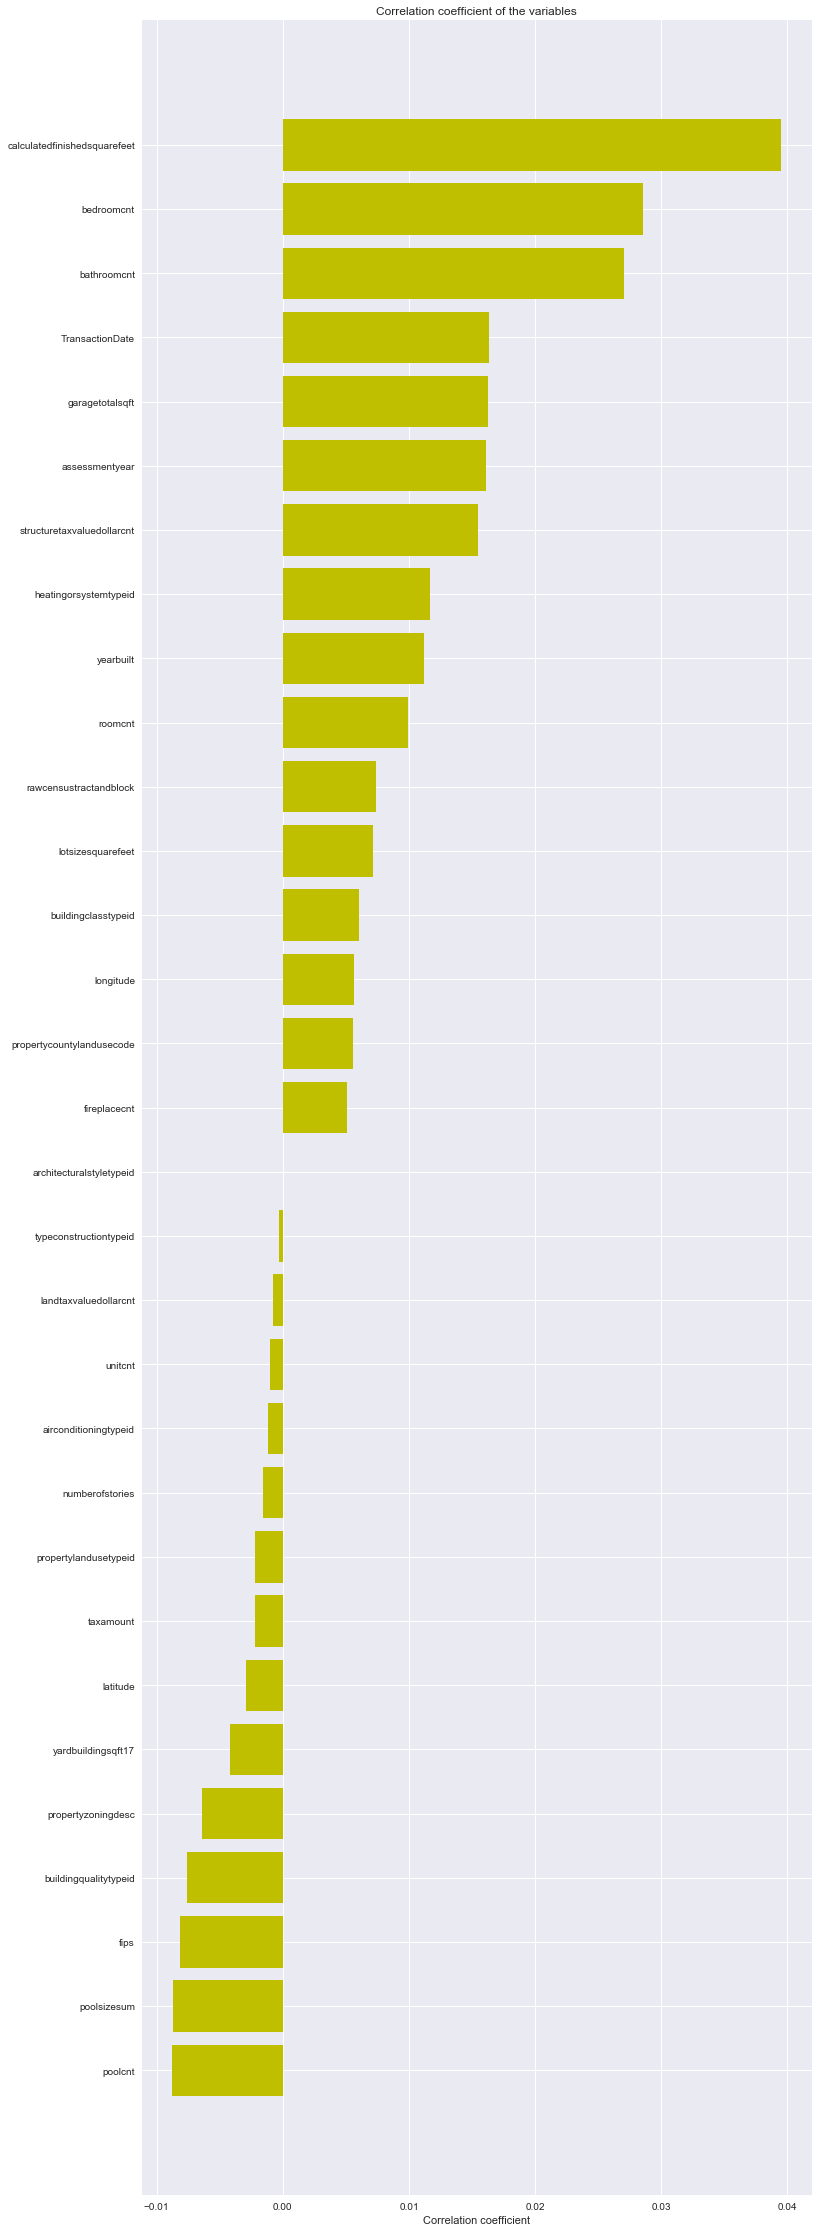

In [277]:
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
'''
fontdict = {'fontsize': 22,
 'fontweight': mlp.rcParams['axes.titleweight'],
 'verticalalignment': 'baseline'}
'''
ax.set_yticklabels(corr_df.col_labels.values,rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

In [278]:
corr_df_sel = corr_df.ix[(corr_df['corr_values']>0.012) | (corr_df['corr_values'] < -0.004)]
corr_df_sel
#plot_corr(corr_df_sel)

,col_labels,corr_values
14,poolcnt,-0.008749
15,poolsizesum,-0.008703
7,fips,-0.008170
5,buildingqualitytypeid,-0.007613
18,propertyzoningdesc,-0.006403
23,yardbuildingsqft17,-0.004144
26,structuretaxvaluedollarcnt,0.015505
27,assessmentyear,0.016091
9,garagetotalsqft,0.016254
30,TransactionDate,0.016385


In [279]:
after_corr_df = scaling_finished_df.copy()

In [280]:
l = corr_df_sel['col_labels'].values
l = np.append(l,'logerror')
cols_to_del = [col for col in after_corr_df.columns.values if col not in l] 

In [281]:
after_corr_df = after_corr_df.drop(cols_to_del,axis=1)

In [282]:
after_corr_feat_df = after_corr_df.drop('logerror',axis=1)

In [283]:
from sklearn.cross_validation import train_test_split

In [284]:
X_train, X_test, y_train, y_test = train_test_split(after_corr_feat_df,after_corr_df['logerror'],test_size=0.25, random_state=42)

# Success
print "Training and testing split was successful."
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

Training and testing split was successful.
(125890, 13)
(125890,)
(41964, 13)
(41964,)


In [285]:
X_test_1, X_test_2, y_test_1,y_test_2 = train_test_split(X_test,y_test,test_size=0.5, random_state=28)

In [286]:
print X_test_1.shape
print y_test_1.shape

(20982, 13)
(20982,)


In [287]:
split = 80000
X_train, y_train, X_valid, y_valid = X_train[:split], y_train[:split], X_train[split:], y_train[split:]

In [288]:
from sklearn.metrics import mean_absolute_error

In [289]:
from sklearn.ensemble import GradientBoostingRegressor
from time import time

In [291]:
d_train = xgb.DMatrix(X_train, y_train)
d_valid = xgb.DMatrix(X_valid)

In [292]:
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

#clf = xgb.train(xgb_params, d_train, 100, watchlist, verbose_eval=10) 

# Naive (Mean; y_pred=0.01412704) model performance on test1: 0.070903987

#same as clf results above
#model = xgb.train(xgb_params, d_train, 100)
start = time()
model = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=1000, subsample=0.8, 
                                  max_depth=6 )
model = model.fit(X_train, y_train)
#xgb_pred = model.predict(d_valid)
pred = model.predict(X_valid)
e = mean_absolute_error(y_valid,pred)
end = time()

In [293]:
start = time()
pred = model.predict(X_test_1)
e = mean_absolute_error(y_test_1,pred)
end = time()

In [294]:
# stats for Gradient Boost regressor for test_1 sample (no training)
print('time taken ', end-start)
print ('absolute error', e)

('time taken ', 0.45147705078125)
('absolute error', 0.079195733125582091)


In [ ]:
print('Building DMatrix...')

In [ ]:
start = time()
d_train = xgb.DMatrix(X_train, y_train)
d_valid = xgb.DMatrix(X_valid)

xgb_params = {
    'eta': 0.005,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'silent': 1
}
xgbmodel = xgb.train(xgb_params,d_train,num_boost_round=2000)
pred = xgbmodel.predict(d_valid)
e = mean_absolute_error(y_valid,pred)
end = time()

In [ ]:
#Same stats as below except num of rounds changed to 2000
print('time taken ', end-start)
print ('For validation absolute error', e)

# stats for XGBoost regressor for test_1 sample for config2
d_test1 = xgb.DMatrix(X_test_1)
predT =  xgbmodel.predict(d_test1)
eT = mean_absolute_error(y_test_1,predT)
print ('For test1 absolute error', eT)

In [ ]:
#Same stats as below except num of rounds changed to 1500
print('time taken ', end-start)
print ('For validation absolute error', e)

# stats for XGBoost regressor for test_1 sample for config2
d_test1 = xgb.DMatrix(X_test_1)
predT =  xgbmodel.predict(d_test1)
eT = mean_absolute_error(y_test_1,predT)
print ('For test1 absolute error', eT)
d_test2 = xgb.DMatrix(X_test_2)
predT2 =  xgbmodel.predict(d_test2)
eT2 = mean_absolute_error(y_test_2,predT2)
print ('For test2 absolute error', eT2)

In [ ]:
# stats for XGBoost regressor for validation sample with training for config2
#    'eta': 0.001,
#   'max_depth': 7,
#    'subsample': 0.6,
#    'colsample_bytree': 0.6,
#      num_boost_round : 1000

print('time taken ', end-start)
print ('For validation absolute error', e)

# stats for XGBoost regressor for test_1 sample for config2
d_test1 = xgb.DMatrix(X_test_1)
predT =  xgbmodel.predict(d_test1)
eT = mean_absolute_error(y_test_1,predT)
print ('For test1 absolute error', eT)
d_test2 = xgb.DMatrix(X_test_2)
predT2 =  xgbmodel.predict(d_test2)
eT2 = mean_absolute_error(y_test_2,predT2)
print ('For test2 absolute error', eT2)

In [ ]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xgbmodel, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [ ]:
# stats for XGBoost regressor for validation sample with training for config2
#    'eta': 0.005,
#   'max_depth': 8,
#    'subsample': 0.7,
#    'colsample_bytree': 0.7,
#      num_boost_round : 10000

print('time taken ', end-start)
print ('For validation absolute error', e)

# stats for XGBoost regressor for test_1 sample for config2
d_test1 = xgb.DMatrix(X_test_1)
predT =  xgbmodel.predict(d_test1)
eT = mean_absolute_error(y_test_1,predT)
print ('For test1 absolute error', eT)
d_test2 = xgb.DMatrix(X_test_2)
predT2 =  xgbmodel.predict(d_test2)
eT2 = mean_absolute_error(y_test_2,predT2)
print ('For test2 absolute error', eT2)

In [ ]:
# stats for XGBoost regressor for validation sample with training for config2
#    'eta': 0.005,
#   'max_depth': 8,
#    'subsample': 0.7,
#    'colsample_bytree': 0.7,
#      num_boost_round : 1000

print('time taken ', end-start)
print ('For validation absolute error', e)

# stats for XGBoost regressor for test_1 sample for config2
d_test1 = xgb.DMatrix(X_test_1)
predT =  xgbmodel.predict(d_test1)
eT = mean_absolute_error(y_test_1,predT)
print ('For test1 absolute error', eT)
d_test2 = xgb.DMatrix(X_test_2)
predT2 =  xgbmodel.predict(d_test2)
eT2 = mean_absolute_error(y_test_2,predT2)
print ('For test2 absolute error', eT2)

In [ ]:
# stats for XGBoost regressor for validation sample with training
print('time taken ', end-start)
print ('absolute error', e)

In [ ]:
start = time()
pred = xgbmodel.predict(X_test_1)
e = mean_absolute_error(y_test_1,pred)
end = time()

In [ ]:
d_test1 = xgb.DMatrix(X_test_1) # 0.070964954936066027
xgb_pred = model.predict(d_test1)
mean_absolute_error(y_test_1,xgb_pred)

In [ ]:
d_test2 = xgb.DMatrix(X_test_2)  # 0.070355333169546716
xgb_pred = model.predict(d_test2)
mean_absolute_error(y_test_2,xgb_pred)

In [ ]:
mean_absolute_error(y_test_1,y_pred)

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(y_test_1,xgb_pred)

In [ ]:
#data[np.where(data.irow(0)[data.columns].notnull())[0]]
#middle_pred = data_trans_reduced_comb_f[~data_trans_reduced_comb_f['parcelid'].isin(top_10p_pred['parcelid']) & ~data_trans_reduced_comb_f['parcelid'].isin(worst_10p_pred['parcelid'])]

In [ ]:
d = {'eta':0.005,'max_depth':8,'subsample':0.7,'colsample_bytree':0.7 ,'num_boost_round':1000, 'valScore':0.070660886278811383, 
    'test1Score':0.071708082828990508, 'test2Score':0.070926445195721943}
finalRes = pd.DataFrame(data=d)